In [5]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm

import torch

## Test importable Dynamic Acceptance Loop

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

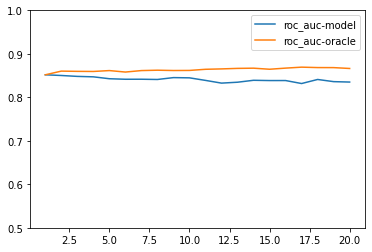

In [6]:
n_years = 20

model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

## Test importable Autoencoder

In [7]:
import autoencoder as aenc
import importlib
importlib.reload(aenc)

<module 'autoencoder' from 'c:\\Projects\\Information-Systems-Seminar\\reject-infer-autoencoder\\notebooks\\../src\\autoencoder.py'>

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=2, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=68, bias=True)
  )
)
Epoch 1 of 20, Train Loss: 0.938
Epoch 2 of 20, Train Loss: 0.852
Epoch 3 of 20, Train Loss: 0.826
Epoch 4 of 20, Train Loss: 0.815
Epoch 5 of 20, Train Loss: 0.801
Epoch 6 of 20, Train Loss: 0.790
Epoch 7 of 20, Train Loss: 0.782
Epoch 8 of 20, Train Loss: 0.776
Epoch 9 of 20, Train Loss: 0.771
Epoch 10 of 20, Train Loss: 0.767
Epoch 11 of 20, Train Loss: 0.764
Epoch 12 of 20, Train Loss: 0.761
Epoch 13 of 20, Train Loss: 0.759
Epoch 14 of 20, Train Loss: 0.757
Epoch 15 of 20, Train Loss: 0.755
Epoch 16 of 20, Train Loss: 0.752
Epoch 17 of 20, Train Loss: 0.749
Epoch 18 of 20, Train Loss: 0.748
Epoch 19 of 20, Train Loss: 0.747
Epoch 20 of 20, Train Loss: 0.745


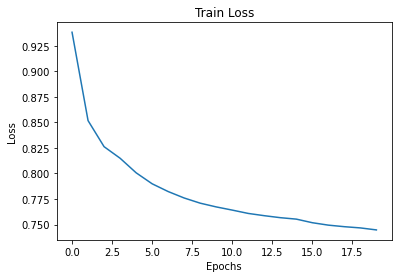

In [8]:
BATCH_SIZE = 1000
EPOCHS = 20

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

shape = [dataset.x.shape[1], 35, 2, 35, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss = aenc.train(net, data_loader, EPOCHS)               

plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Itteration: 0) Accepted: 1809 | Denied: 4266 - New train set size: (16809, 2)
Itteration: 1) Accepted: 1820 | Denied: 4255 - New train set size: (18629, 2)
Itteration: 2) Accepted: 1820 | Denied: 4255 - New train set size: (20449, 2)
Itteration: 3) Accepted: 1821 | Denied: 4254 - New train set size: (22270, 2)
Itteration: 4) Accepted: 1795 | Denied: 4280 - New train set size: (24065, 2)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25887, 2)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27709, 2)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29531, 2)
Itteration: 8) Accepted: 1810 | Denied: 4265 - New train set size: (31341, 2)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33163, 2)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (34985, 2)
Itteration: 11) Accepted: 1811 | Denied: 4264 - New train set size: (36796, 2)
Itteration: 12) Accepted: 1820 | Denied: 4255 - New train set 

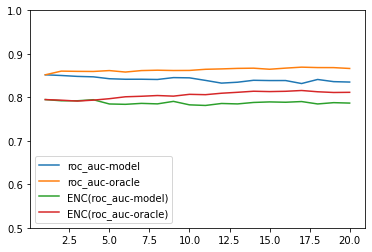

In [10]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics2 = iteration[3]
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()